In [1]:
import pandas as pd
import numpy as np

import os.path as op
import sys

sys.path.append(op.abspath('../code'))

import plotting_tools

import importlib

import data_loaders as dload
import clusterize as cluster

In [2]:
path_to_xls = '/Users/AlexCionca/Documents/BrainHack-2023/Piriform_neurons/data/'
my_matrix = dload.get_neuron_matrix(path_to_xls)
my_matrix

/Users/AlexCionca/opt/miniconda3/envs/STD/lib/python3.7/site-packages/pandas/core/frame.py:9203: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


Successfully converted data from 37 dendrites (30 features found).
Successfully converted data from 37 dendrites (30 features found).
Successfully converted data from 51 dendrites (30 features found).
Successfully converted data from 46 dendrites (30 features found).
Successfully converted data from 66 dendrites (30 features found).
Successfully converted data from 46 dendrites (30 features found).
Successfully converted data from 27 dendrites (30 features found).
Successfully converted data from 33 dendrites (30 features found).
Successfully converted data from 21 dendrites (30 features found).
Successfully converted data from 74 dendrites (30 features found).
Successfully converted data from 23 dendrites (30 features found).
Successfully converted data from 59 dendrites (30 features found).
Successfully converted data from 32 dendrites (30 features found).
Successfully converted data from 87 dendrites (30 features found).
Successfully converted data from 62 dendrites (30 features fou

,Filament BoundingBoxAA Length X,Filament BoundingBoxAA Length Y,Filament BoundingBoxAA Length Z,Filament BoundingBoxOO Length A,Filament BoundingBoxOO Length B,Filament BoundingBoxOO Length C,Filament Dendrite Length (sum),Filament Distance from Origin,Depth-Apical-mean,Level-Apical-mean,...,Level-Basal-mean,Dendrite Branching Angle-Basal-mean,Dendrite Branching Angle B-Basal-mean,Dendrite Length-Basal-mean,Dendrite Orientation Angle-Basal-mean,Dendrite Straightness-Basal-mean,dendrites-count,Basal-count,Apical-count,level_1-count
id,,,,,,,,,,,,,,,,,,,,,
220803c2,397.671997,367.519012,74.598099,78.401199,300.372986,481.835999,3199.409912,588.359009,1.000000,1.500000,...,1.826087,33.507574,25.262470,82.586829,-48.273287,0.929221,37.0,23.0,14.0,18.0
220728c6,599.765991,406.221008,84.741898,76.656898,250.242004,641.146973,3125.620117,588.575989,2.700000,2.250000,...,1.375000,23.235501,20.388471,63.169632,-8.584363,0.902760,51.0,16.0,20.0,19.0
220804c2,515.750000,548.078003,41.285400,46.428600,529.473022,526.778992,3914.820068,444.289001,1.714286,1.428571,...,1.375000,36.824632,32.913235,74.645122,-14.950824,0.911412,46.0,16.0,7.0,21.0
220831c4,232.867996,210.024002,33.973202,31.313101,139.182007,292.226990,1386.290039,434.790985,3.333333,2.809524,...,2.477273,34.713013,45.723158,20.376204,21.603243,0.938812,66.0,44.0,21.0,13.0
220729c3,460.346008,375.755005,56.962799,63.419399,359.394012,468.649994,4130.500000,625.966003,2.142857,1.714286,...,2.625000,30.743026,23.891336,88.418938,-46.275719,0.915908,46.0,32.0,14.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220802c9,561.872986,546.406006,47.063400,49.915001,577.502991,537.882019,2837.000000,1120.599976,4.206897,2.310345,...,1.200000,16.306020,14.798380,32.718801,-66.440581,0.940670,35.0,5.0,29.0,12.0
220728c5,18.957300,81.177200,48.012199,7.305410,20.284300,93.685097,115.085999,736.338989,3.675000,2.750000,...,1.681818,16.830166,28.140820,61.109693,-0.822688,0.899236,144.0,38.0,80.0,32.0
220804c1,219.255997,334.191010,22.972700,21.813299,116.309998,363.174988,1607.780029,544.145020,2.375000,2.562500,...,1.916667,39.687725,40.980310,38.972638,-50.896333,0.884011,28.0,12.0,16.0,9.0


In [6]:
is_na_idx = np.where(my_matrix.isna())[0]
print(is_na_idx)
my_matrix.iloc[is_na_idx]

[28 28 28 28 28 28 28 28 39 39 39 39 39 39 39 39 58 58 58 58]


,Filament BoundingBoxAA Length X,Filament BoundingBoxAA Length Y,Filament BoundingBoxAA Length Z,Filament BoundingBoxOO Length A,Filament BoundingBoxOO Length B,Filament BoundingBoxOO Length C,Filament Dendrite Length (sum),Filament Distance from Origin,Depth-Apical-mean,Level-Apical-mean,...,Level-Basal-mean,Dendrite Branching Angle-Basal-mean,Dendrite Branching Angle B-Basal-mean,Dendrite Length-Basal-mean,Dendrite Orientation Angle-Basal-mean,Dendrite Straightness-Basal-mean,dendrites-count,Basal-count,Apical-count,level_1-count
id,,,,,,,,,,,,,,,,,,,,,
221005c1,598.138000,626.291016,92.129303,95.135399,599.177979,698.518982,4335.859863,840.005005,2.5,2.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,12.0,14.0
221005c1,598.138000,626.291016,92.129303,95.135399,599.177979,698.518982,4335.859863,840.005005,2.5,2.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,12.0,14.0
221005c1,598.138000,626.291016,92.129303,95.135399,599.177979,698.518982,4335.859863,840.005005,2.5,2.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,12.0,14.0
221005c1,598.138000,626.291016,92.129303,95.135399,599.177979,698.518982,4335.859863,840.005005,2.5,2.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,12.0,14.0
221005c1,598.138000,626.291016,92.129303,95.135399,599.177979,698.518982,4335.859863,840.005005,2.5,2.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,12.0,14.0
221005c1,598.138000,626.291016,92.129303,95.135399,599.177979,698.518982,4335.859863,840.005005,2.5,2.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,12.0,14.0
221005c1,598.138000,626.291016,92.129303,95.135399,599.177979,698.518982,4335.859863,840.005005,2.5,2.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,12.0,14.0
221005c1,598.138000,626.291016,92.129303,95.135399,599.177979,698.518982,4335.859863,840.005005,2.5,2.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,12.0,14.0
220803c5,280.454010,169.817993,59.319901,48.362202,175.466995,277.036011,1014.390015,683.142029,3.3,1.950000,...,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,20.0,8.0


In [10]:
cluster_df = my_matrix.dropna(axis = 0).apply(cluster.normalize).dropna(axis = 1)

feat_to_del = ['Filament BoundingBoxAA Length X', 'Filament BoundingBoxAA Length Y', 'Filament BoundingBoxAA Length Z']
cluster_df = cluster_df.drop(columns = feat_to_del)

cluster_df

,Filament BoundingBoxOO Length A,Filament BoundingBoxOO Length B,Filament BoundingBoxOO Length C,Filament Dendrite Length (sum),Filament Distance from Origin,Depth-Apical-mean,Level-Apical-mean,Dendrite Branching Angle-Apical-mean,Dendrite Branching Angle B-Apical-mean,Dendrite Length-Apical-mean,...,Level-Basal-mean,Dendrite Branching Angle-Basal-mean,Dendrite Branching Angle B-Basal-mean,Dendrite Length-Basal-mean,Dendrite Orientation Angle-Basal-mean,Dendrite Straightness-Basal-mean,dendrites-count,Basal-count,Apical-count,level_1-count
id,,,,,,,,,,,,,,,,,,,,,
220803c2,1.065812,-0.171954,-0.159464,-0.076655,-0.672783,-1.222098,-1.092553,-0.523568,-1.167264,1.802070,...,-0.186757,0.789680,0.069859,0.700828,-0.057031,0.504333,-0.548356,-0.109519,-0.714499,0.471671
220728c6,0.990331,-0.512600,0.614363,-0.112559,-0.671745,-0.128295,-0.097865,-0.032276,-0.701043,0.518216,...,-0.849404,-0.232371,-0.336597,-0.033634,0.712832,-0.229611,-0.247818,-0.410856,-0.411783,0.625872
220804c2,-0.317735,1.384810,0.058839,0.271434,-1.362272,-0.762517,-1.187285,-0.134480,1.192484,1.194637,...,-0.849404,1.119720,0.707876,0.400430,0.589339,0.010372,-0.355153,-0.410856,-1.067668,0.934272
220831c4,-0.971827,-1.267267,-1.080459,-0.958845,-1.407727,0.279200,0.644204,0.646066,2.205868,-2.070276,...,0.769837,0.909618,1.776129,-1.652312,1.298394,0.770372,0.074188,0.794491,-0.361330,-0.299330
220729c3,0.417506,0.229102,-0.223513,0.376375,-0.492804,-0.486768,-0.808356,0.549960,0.145648,1.806769,...,0.986848,0.514613,-0.044484,0.921430,-0.018283,0.135076,-0.355153,0.277913,-0.714499,-0.453530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220802c9,-0.166868,1.711180,0.112770,-0.252989,1.874409,0.841262,-0.017833,0.655047,0.846395,1.763147,...,-1.106480,-0.921841,-0.802770,-1.185448,-0.409430,0.821917,-0.591290,-0.884385,0.042291,-0.453530
220728c5,-2.010709,-2.075192,-2.044844,-1.577361,0.035418,0.499033,0.565260,-0.423470,0.145853,0.317711,...,-0.398688,-0.869690,0.309892,-0.111552,0.863388,-0.327366,1.748615,0.536202,2.615379,2.630475
220804c1,-1.382911,-1.422685,-0.735841,-0.851077,-0.884382,-0.337404,0.316588,1.288017,-0.202164,0.576834,...,-0.053695,1.404592,1.380611,-0.948895,-0.107911,-0.749672,-0.741559,-0.583049,-0.613594,-0.916131


Clustering yielded 6 clusters
Groups: [16, 9, 23, 3, 14, 3]


,avg_radius,max_radius,feat_by_radius,Filament BoundingBoxOO Length A,Filament BoundingBoxOO Length B,Filament BoundingBoxOO Length C,Filament Dendrite Length (sum),Filament Distance from Origin,Depth-Apical-mean,Level-Apical-mean,...,Level-Basal-mean,Dendrite Branching Angle-Basal-mean,Dendrite Branching Angle B-Basal-mean,Dendrite Length-Basal-mean,Dendrite Orientation Angle-Basal-mean,Dendrite Straightness-Basal-mean,dendrites-count,Basal-count,Apical-count,level_1-count
0,3.481838,5.841208,"[Dendrite Orientation Angle-Basal-mean, Dendri...",11.468981,11.630938,10.567836,8.491882,9.973709,10.831779,9.595092,...,10.753985,8.267011,7.413037,7.792857,5.075105,8.487116,6.585009,9.072388,13.950171,10.716916
1,4.066593,5.30244,"[Apical-count, Dendrite Orientation Angle-Apic...",4.03609,5.566835,7.973088,3.584389,6.205682,3.622751,4.696777,...,4.688839,4.552688,8.376658,9.408771,9.357407,6.79653,4.221848,7.605165,2.589905,5.654009
2,3.586359,5.354453,"[dendrites-count, Depth-Basal-mean, Basal-coun...",22.786238,14.676863,15.597675,9.192938,15.332927,9.293336,12.847979,...,12.251152,12.731885,17.346503,22.126179,12.90257,17.282779,6.160102,9.017642,9.796598,14.052335
3,4.527626,4.984256,"[Dendrite Branching Angle-Basal-mean, Dendrite...",3.188763,1.297018,0.73928,1.760737,1.685069,4.39687,4.747175,...,2.755116,0.421007,0.517078,1.392327,1.208343,1.770995,4.13598,3.501246,4.002581,3.392405
4,3.363722,4.760613,"[dendrites-count, Dendrite Orientation Angle-A...",6.462025,10.202549,10.184419,8.231872,11.690044,5.475434,7.383292,...,4.848995,13.615168,9.876934,9.998517,4.257739,12.136782,3.422457,4.403206,5.297533,5.815552
5,2.393291,2.584335,"[Dendrite Branching Angle B-Apical-mean, Level...",3.002594,0.54684,0.797873,1.218314,0.739981,0.0,0.0,...,1.631889,0.608429,0.873659,1.980348,0.964798,0.267889,0.95886,1.922815,0.0,2.364404


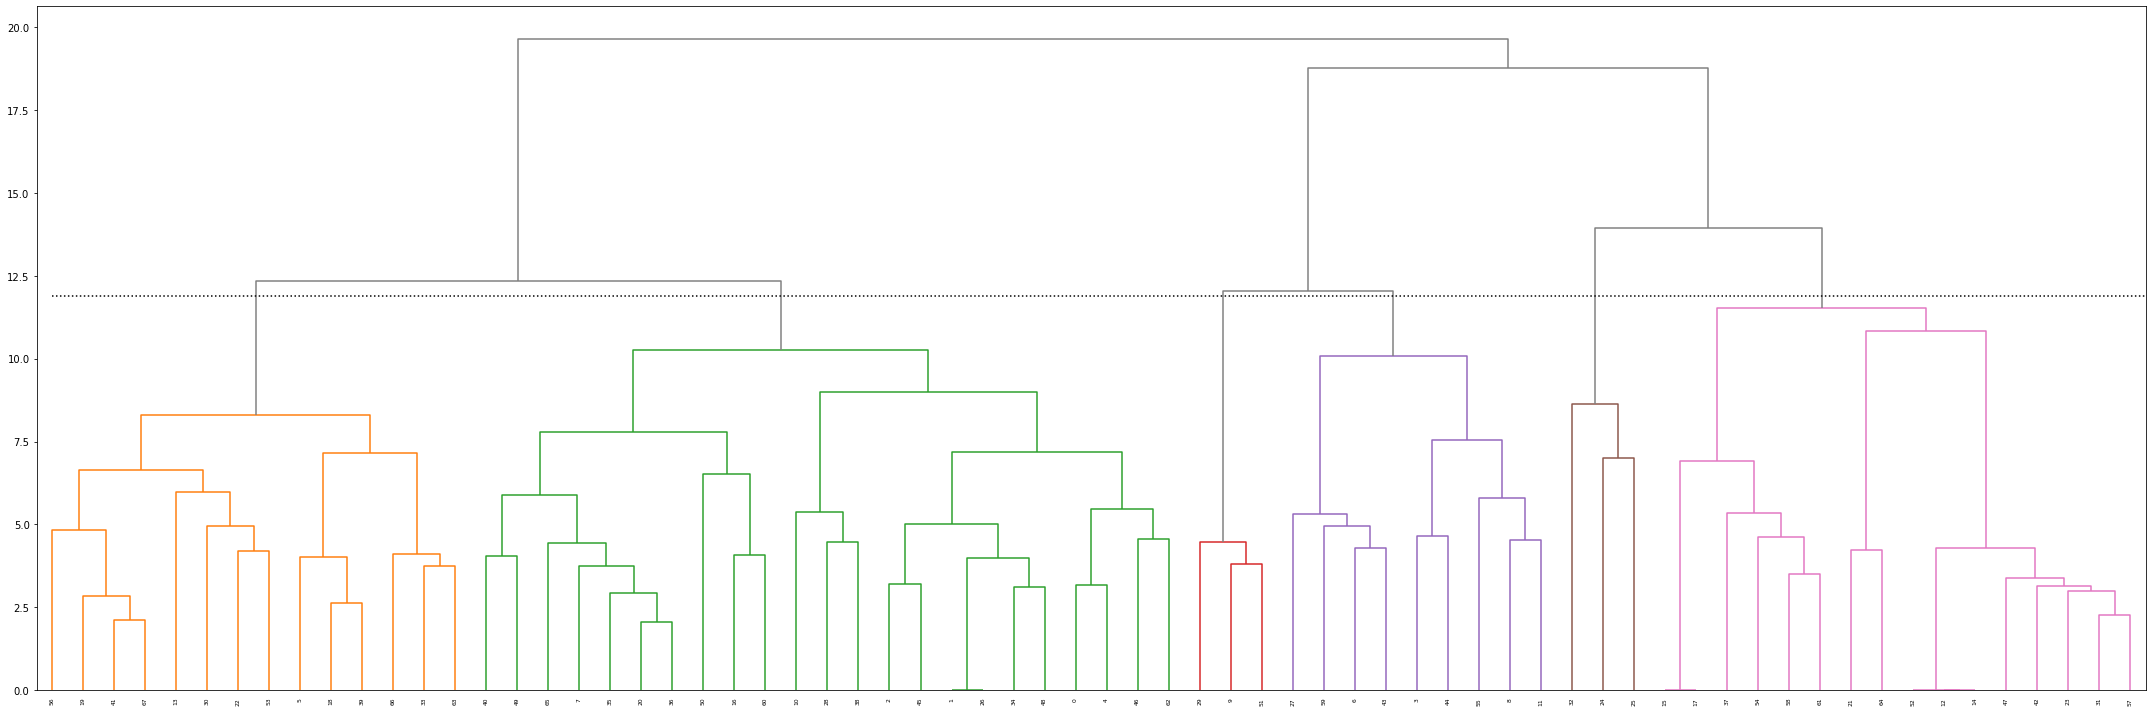

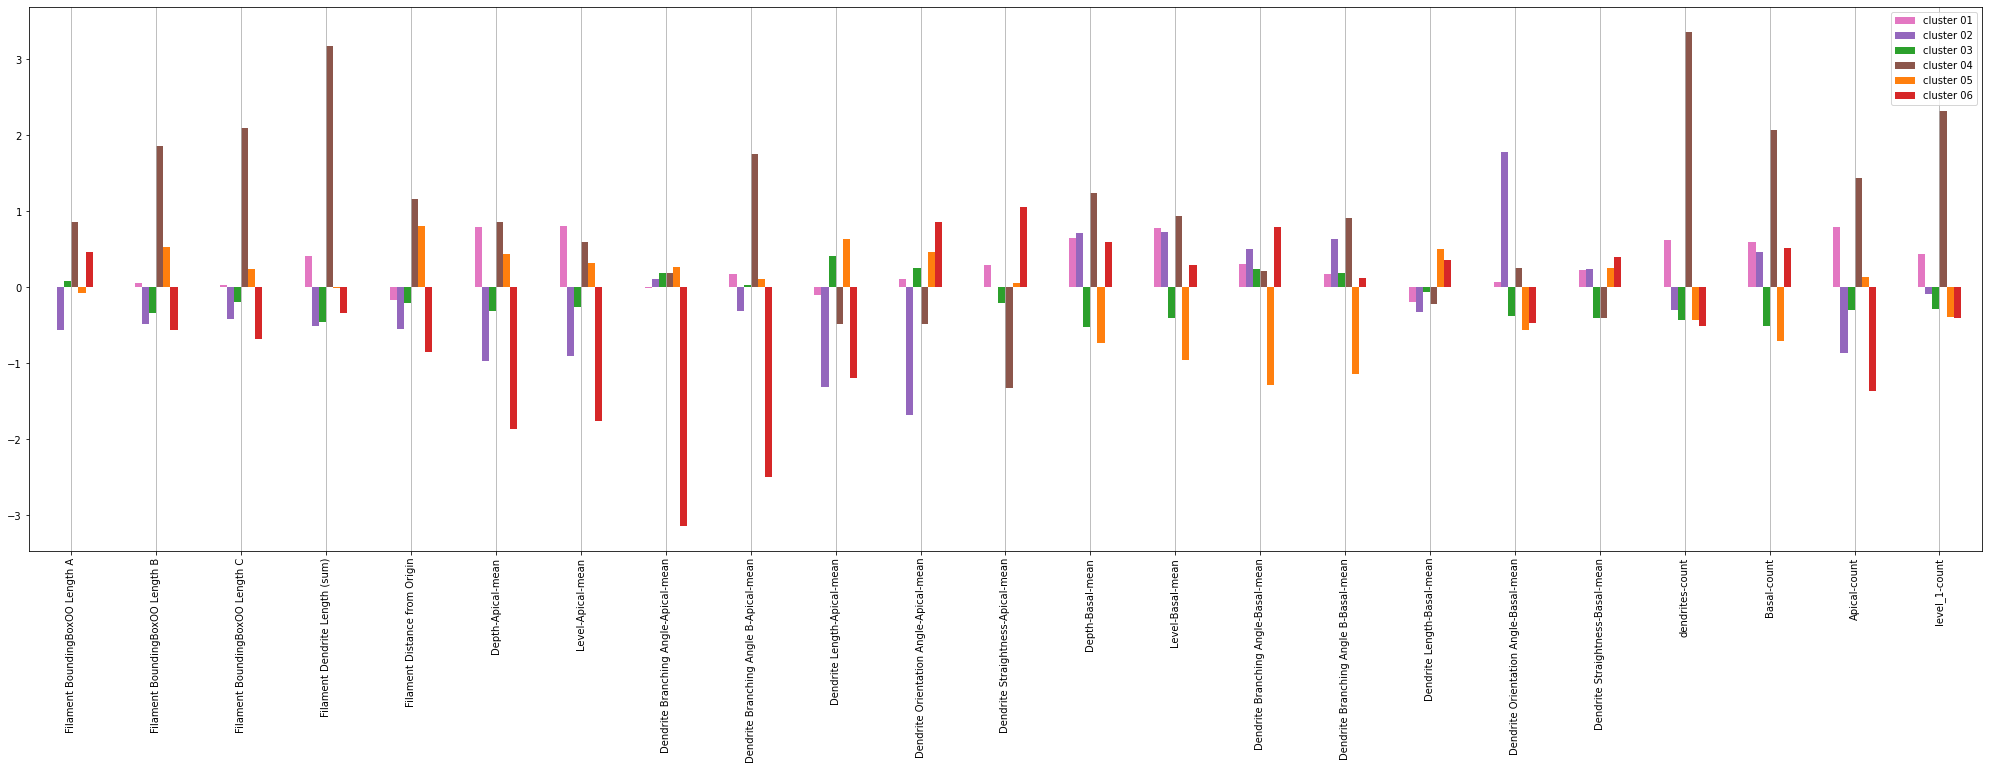

In [8]:
importlib.reload(cluster)

cluster_model, label_2_color = cluster.hierarchical_cstm(cluster_df, d_thresh = 11.9, figsize = (30, 10))

labels = cluster_model.labels_
n_clusters = labels.max() + 1

plotting_tools.save_figure(op.join(f'/Users/AlexCionca/Documents/BrainHack-2023/Piriform_neurons/figures/hierarchical-tree-{n_clusters:02d}k.png'))

# full_model, feature_df_nona.iloc[:, 1:], plot = True, col = lab2col
centroids = cluster.get_centroids(cluster_model, cluster_df, col = label_2_color, plot = True)

dist_to_centroid = cluster.get_centroid_distance(cluster_model, cluster_df, centroids)

dist_to_centroid

In [22]:
labels

for i in range(n_clusters):
    print(f'label is {i}', cluster_df.loc[labels == i].index.tolist())

label is 0 ['220728c7', '220728c62', '22072c4', '220728c4', '220728c5', '220728c9', '221003c6', '221005c3', '220909c1', '220726c2', '220728c7', '220804c3', '220729c2', '220802c6', '220804c9', '220728c5']
label is 1 ['220831c4', '220729c6', '220804c7', '220831c6', '220729c4', '220803c6', '220909c3', '220831c5', '220729c5']
label is 2 ['220803c2', '220728c6', '220804c2', '220729c3', '220802c2', '221003c1', '220726t2', '220802c11', '220728c6-', '220804c8', '221005c2', '220728c2', '220728c3', '220804c5', '221003c8', '220802c3-', '220804c6', '220909c4', '220726c3', '220909c2', '220902c4', '220804c4', '220804c1']
label is 3 ['221003c7', '220905c2', '221003c4']
label is 4 ['221022c1', '220726c8', '220729c1', '220802c5', '221003c3', '220905c3', '220905c1', '221003c5', '220726c1', '220726c7', '220727c4-', '220802c9', '220802c4-', '220802c10']
label is 5 ['220909c5', '220902c5', '220803c3']
